In [1]:
import pandas as pd

df = pd.read_csv("../data/CMU_MisCov19_dataset_hydrated.csv")

In [2]:
print("Ratio of label occurrence between those tweets with and those tweets without user location")

t_with_l = df[df.country_code.notnull()]
t_without_l = df[~df.country_code.notnull()]
print( (t_with_l.annotation1.value_counts()/len(t_with_l)) / (t_without_l.annotation1.value_counts()/len(t_without_l)) )

Ratio of label occurrence between those tweets with and those tweets without user location
ambiguous or hard to classify        1.030614
calling out or correction            1.438762
commercial activity or promotion     1.130562
conspiracy                           0.394661
emergency                           15.375643
fake cure                            0.435907
fake treatment                       0.524170
false fact or prevention             1.003824
false public health response              NaN
irrelevant                           1.247585
news                                 2.690738
panic buying                         1.729760
politics                             1.055500
sarcasm or satire                    0.876072
true prevention                      2.694916
true public health response          2.599008
Name: annotation1, dtype: float64


Users with their location specified properly seems to be less likely to post tweets that could be classified to be about "conspiracies", "fake cures" and "fake treatments". While more likely to post tweets labeled "calling out or correction", "news", "panic buying", "true prevention" and "true public health response".

In [3]:
t_with_l["country_code"].value_counts().nlargest(10).sum()/len(t_with_l) # top 10 is about 86 % of all locations.

0.8576329331046312

In [4]:
t_with_l["country_code"].value_counts().nlargest(10)/len(t_with_l)

us    0.532590
gb    0.109348
in    0.063465
ca    0.063036
za    0.019726
ng    0.018010
au    0.015866
fr    0.013293
pk    0.012007
nz    0.010292
Name: country_code, dtype: float64

<AxesSubplot:title={'center':'Label ratio for each country in top 10'}, xlabel='annotation1'>

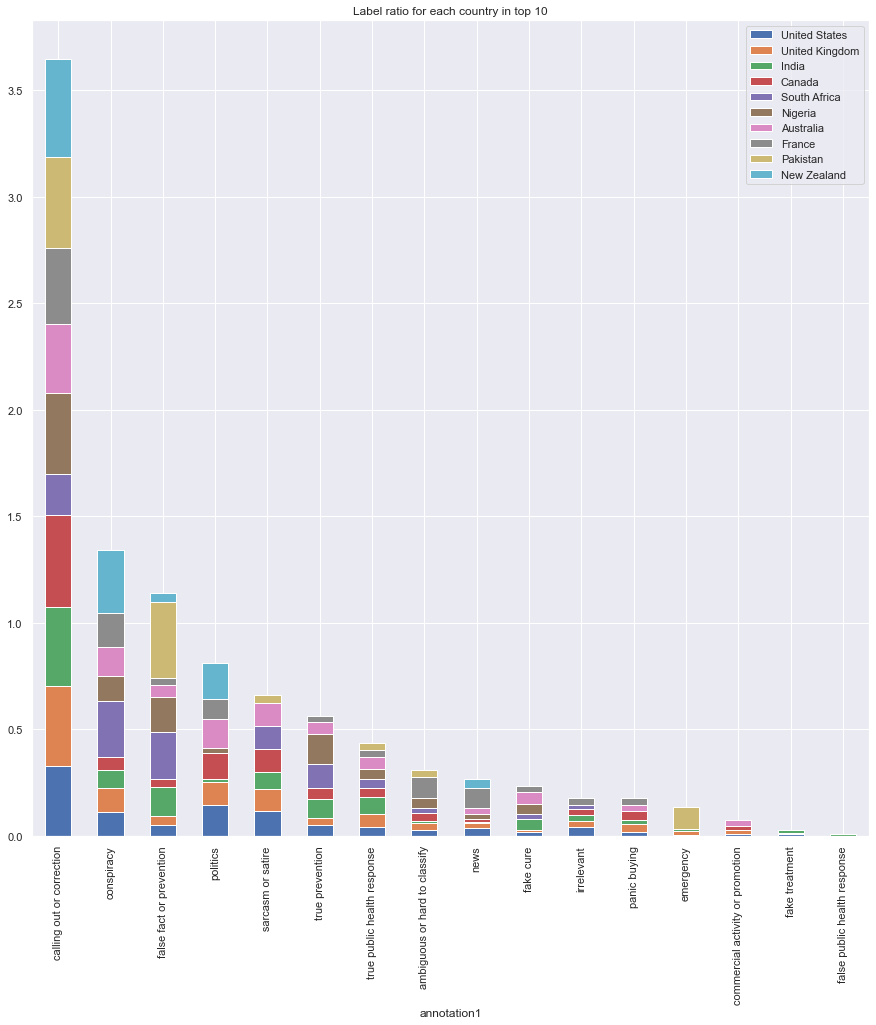

In [5]:
import pycountry
import seaborn as sns
sns.set_theme()

ct = pd.crosstab(t_with_l["annotation1"],t_with_l["country_code"])
columns = t_with_l["country_code"].value_counts().nlargest(10).index.to_list()
ct = ct[columns]
ct = ct/ct.sum()
ct = ct.reindex(ct.sum(axis=1).sort_values(ascending=False).index)
ct.columns = [pycountry.countries.get(alpha_2=c).name for c in ct.columns]
ct.plot(kind="bar",stacked=True, figsize=(15,15), title="Label ratio for each country in top 10")

Seems like there are some differences between countries and their ratio of different labels.

<AxesSubplot:title={'center':'Difference between ratio for true and false'}>

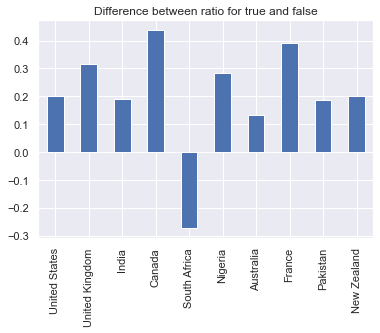

In [6]:
ct = pd.crosstab(t_with_l["annotation1"],t_with_l["country_code"])

def multi_to_binary(df):
    df = df.copy()

    mapping = {'calling out or correction': "true",
                'conspiracy': "false",
                'false fact or prevention': "false",
                'politics': "ambiguous",
                'sarcasm or satire': "false",
                'true prevention': "true",
                'true public health response': "true",
                'ambiguous or hard to classify': "ambiguous",
                'news': "true",
                'fake cure': "false",
                'irrelevant': "ambiguous",
                'panic buying': "ambiguous",
                'emergency': "true",
                'commercial activity or promotion': "ambiguous",
                'fake treatment': "false",
                'false public health response': "false"}
    df.index = [mapping[i] for i in df.index]
    df = df.reset_index()
    return df

ct = multi_to_binary(ct)
ct = ct.groupby("index").sum().drop("ambiguous")

columns = t_with_l["country_code"].value_counts().nlargest(10).index.to_list()
ct = ct[columns]
ct = ct/ct.sum()
ct.columns = [pycountry.countries.get(alpha_2=c).name for c in ct.columns]
ct = ct.T
(ct.true - ct.false).plot(kind="bar", title="Difference between ratio for true and false")

In [7]:
t_with_l_us = t_with_l.copy()
t_with_l_us = t_with_l_us[t_with_l_us.country_code == "us"]

t_with_l_us["state"].value_counts().nlargest(10).sum()/len(t_with_l) # # top 10 is about 30 % of all locations.

0.30403087478559176

<AxesSubplot:title={'center':'Difference between ratio for true and false'}, xlabel='state'>

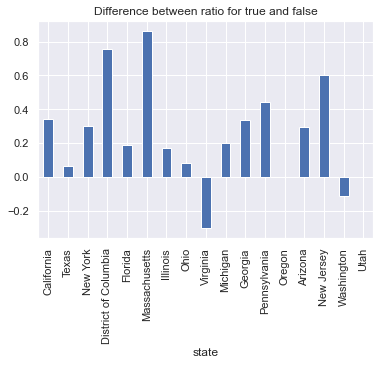

In [8]:
ct = pd.crosstab(t_with_l_us["annotation1"],t_with_l_us["state"])

ct = multi_to_binary(ct)
ct = ct.groupby("index").sum().drop("ambiguous")

columns = t_with_l_us.state.value_counts()[(t_with_l_us.state.value_counts() >= 20)].index
ct = ct[columns]
ct = ct/ct.sum()
ct = ct.T
(ct.true - ct.false).plot(kind="bar", title="Difference between ratio for true and false")

In [9]:
t_with_l.source.value_counts()

Twitter for iPhone            640
Twitter Web App               637
Twitter for Android           438
TweetDeck                     120
Twitter for iPad               84
                             ... 
Vimeo                           1
LatelyAI                        1
ContentCal Studio               1
General Physics Laboratory      1
DigitalTrans4m                  1
Name: source, Length: 74, dtype: int64

<AxesSubplot:title={'center':'Difference between ratio for true and false'}, xlabel='source'>

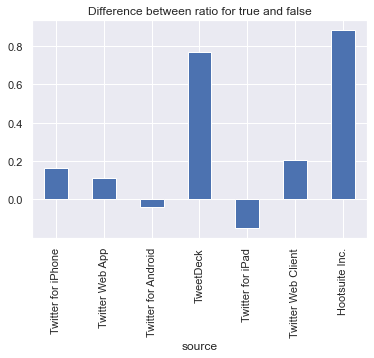

In [10]:
ct = pd.crosstab(t_with_l["annotation1"],t_with_l["source"])

ct = multi_to_binary(ct)
ct = ct.groupby("index").sum().drop("ambiguous")

columns = t_with_l.source.value_counts()[(t_with_l.source.value_counts() >= 50)].index
ct = ct[columns]
ct = ct/ct.sum()
ct = ct.T
(ct.true - ct.false).plot(kind="bar", title="Difference between ratio for true and false")

From the three above figures, the value of the respective variable in each figure seems to have some effect on the difference between true ratio and false ratio.

Something that needs to be remembered for all outputs is that the sample size in most cases is quite low.

In [11]:
df = multi_to_binary(t_with_l.set_index("annotation1")).rename(columns={"index": "annotation1"})
print(len(df[df.annotation1 == "true"]))
print(len(df[df.annotation1 == "false"]))

1132
719


In [12]:
%%capture

import pandas as pd
import us

miscov = pd.read_csv("../data/CMU_MisCov19_dataset_hydrated.csv")
miscov["date"] = pd.to_datetime(miscov.created_at).dt.date
miscov.country_code = miscov.country_code.str.upper()
miscov.state = miscov.state.str.upper()

def create_location_key(country_code, state):
    if country_code == "US" and not pd.isna(state):
        return country_code + "_" + us.states.lookup(state).abbr
    return country_code

miscov["location_key"] = miscov.apply(lambda x: create_location_key(x.country_code, x.state), axis=1)

chunks = []
for chunk in pd.read_csv("../data/covid19_open_data_aggregated.csv", chunksize=500000):
    chunk.date = pd.to_datetime(chunk.date).dt.date
    chunks.append(pd.merge(miscov, chunk, on=["date", "location_key"], how="inner"))

In [160]:
combined = pd.concat(chunks)
combined = combined[combined.location_key.notnull()]

mapping = {'calling out or correction': "true",
            'conspiracy': "false",
            'false fact or prevention': "false",
            'politics': "ambiguous",
            'sarcasm or satire': "false",
            'true prevention': "true",
            'true public health response': "true",
            'ambiguous or hard to classify': "ambiguous",
            'news': "true",
            'fake cure': "false",
            'irrelevant': "ambiguous",
            'panic buying': "ambiguous",
            'emergency': "true",
            'commercial activity or promotion': "ambiguous",
            'fake treatment': "false",
            'false public health response': "false"}

combined["label"] = combined["annotation1"].map(mapping)
combined = combined[combined.label != "ambiguous"]

combined["label"] = combined["label"].map({"false":0,"true":1})
combined = combined.loc[:,~combined.columns.str.contains("cumulative")]
combined = combined.infer_objects()

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


<AxesSubplot:xlabel='date', ylabel='label'>

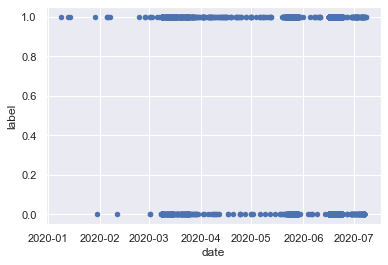

In [161]:
combined.plot("date", "label", kind="scatter")

In [162]:
def get_x_y(df, col):
    return df.loc[:, df.columns != col], df.loc[:, df.columns == col][col]

In [163]:
drop = [
    "tweet_id",
    "author_id",
    "openstreetmap_id",
    "longitude",
    "latitude",
    "status_created_at",
    "annotation1",
    "created_at",
    "text",
    "retweet_count",
    "reply_count",
    "like_count",
    "quote_count",
    "country_code_x",
    "place_id",
    "wikidata_id",
    "datacommons_id",
    "country_code_y",
    "country_name",
    "iso_3166_1_alpha_2",
    "iso_3166_1_alpha_3",
    "aggregation_level",
    ]

df = combined.drop(columns=drop)
df = df.dropna(thresh = len(df)-200, axis = 1).dropna()

print(df.columns)

Index(['source', 'date', 'location_key', 'new_confirmed', 'new_deceased',
       'population', 'population_male', 'population_female',
       'population_age_00_09', 'population_age_10_19', 'population_age_20_29',
       'population_age_30_39', 'population_age_40_49', 'population_age_50_59',
       'population_age_60_69', 'population_age_70_79',
       'population_age_80_and_older', 'area_sq_km', 'school_closing',
       'workplace_closing', 'cancel_public_events',
       'restrictions_on_gatherings', 'public_transport_closing',
       'stay_at_home_requirements', 'restrictions_on_internal_movement',
       'international_travel_controls', 'income_support', 'debt_relief',
       'public_information_campaigns', 'testing_policy', 'contact_tracing',
       'facial_coverings', 'vaccination_policy', 'stringency_index',
       'average_temperature_celsius', 'minimum_temperature_celsius',
       'maximum_temperature_celsius', 'rainfall_mm', 'dew_point',
       'relative_humidity', 'life_expec

In [164]:
print(df[df.columns].corr()["label"].nlargest(16).iloc[1:])

mobility_residential                 0.095370
life_expectancy                      0.057916
cancel_public_events                 0.040147
contact_tracing                      0.038684
income_support                       0.035007
debt_relief                          0.032553
school_closing                       0.030652
workplace_closing                    0.028936
public_information_campaigns         0.026020
stay_at_home_requirements            0.022327
stringency_index                     0.022064
restrictions_on_gatherings           0.005254
new_deceased                        -0.001127
restrictions_on_internal_movement   -0.004739
public_transport_closing            -0.008798
Name: label, dtype: float64


In [165]:
df[df.columns].corr()["label"].nsmallest(15)

mobility_transit_stations        -0.097308
rainfall_mm                      -0.077073
mobility_workplaces              -0.068874
mobility_retail_and_recreation   -0.068393
mobility_grocery_and_pharmacy    -0.059235
new_confirmed                    -0.056759
dew_point                        -0.045056
minimum_temperature_celsius      -0.042490
mobility_parks                   -0.039983
maximum_temperature_celsius      -0.037459
average_temperature_celsius      -0.033129
population_age_80_and_older      -0.033072
relative_humidity                -0.030065
population_age_70_79             -0.026656
population_age_60_69             -0.023462
Name: label, dtype: float64

In [166]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import minmax_scale

# keep = [
#     "cancel_public_events",
#     "contact_tracing",
#     "debt_relief",
#     "facial_coverings",
#     "income_support",
#     "international_travel_controls",
#     "label",
#     "location_key", 
#     "life_expectancy",
#     "mobility_residential",
#     "mobility_transit_stations",
#     "mobility_workplaces",
#     "mobility_retail_and_recreation",
#     "mobility_grocery_and_pharmacy",
#     "new_deceased",
#     "new_confirmed", 
#     "public_transport_closing",
#     "public_information_campaigns",
#     "restrictions_on_gatherings",
#     "restrictions_on_internal_movement",
#     "rainfall_mm",
#     "stay_at_home_requirements",
#     "stringency_index",
#     "school_closing",
#     "source",
#     "testing_policy",
#     "vaccination_policy",
#     "workplace_closing",
#     ]

# df = df[keep]
tmp_df = df.copy()
tmp_df.source = tmp_df.source.astype('category').cat.codes
tmp_df.location_key = tmp_df.location_key.astype('category').cat.codes
tmp_df = tmp_df.select_dtypes(['number'])

clf = RandomForestClassifier(n_estimators=1000)

tmp_df = tmp_df.sample(frac=1).groupby("label").head(tmp_df["label"].value_counts().min()) # Makes sure there are equal amounts of each label.
tmp_df = pd.DataFrame(minmax_scale(tmp_df), columns=tmp_df.columns)

x, y = get_x_y(tmp_df, "label")
cross_val_score(clf, x, y).mean()

0.5874744525547445

In [167]:
import geopandas as gp

grouped = df.groupby("location_key").mean().reset_index()
usmap = gp.read_file("../data/USA.shp")
grouped = grouped[grouped.location_key.str.contains("US_")]
grouped["STUSPS"] = grouped[grouped.location_key.str.contains("US_")].location_key.apply(lambda x: x[3:])
usmap = pd.merge(usmap, grouped, on="STUSPS")

In [168]:
usmap["rainfall_mm"] = minmax_scale(usmap.rainfall_mm)

Text(0.5, 1.0, 'average rainfall per state, redder means higher')

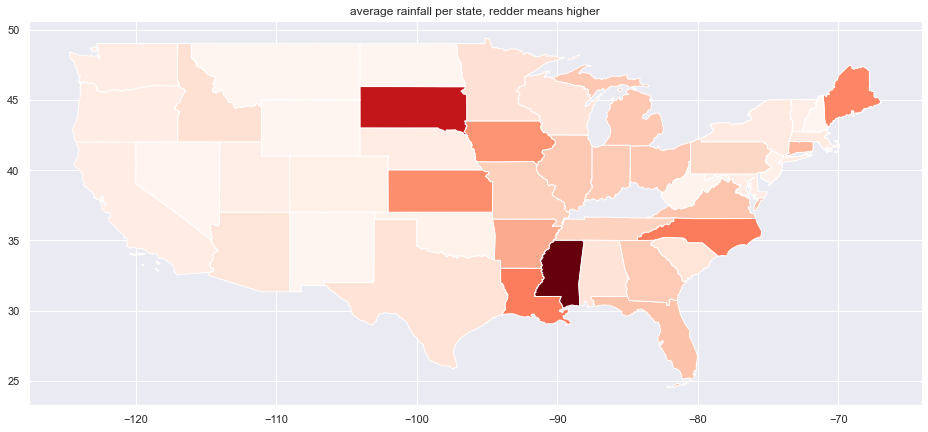

In [178]:
title = "average rainfall per state, redder means higher"
ax = usmap.plot(column="rainfall_mm", cmap="Reds", figsize=(16, 16))
ax.set_title(title)

Text(0.5, 1.0, 'true/false ratio per state, redder means more false')

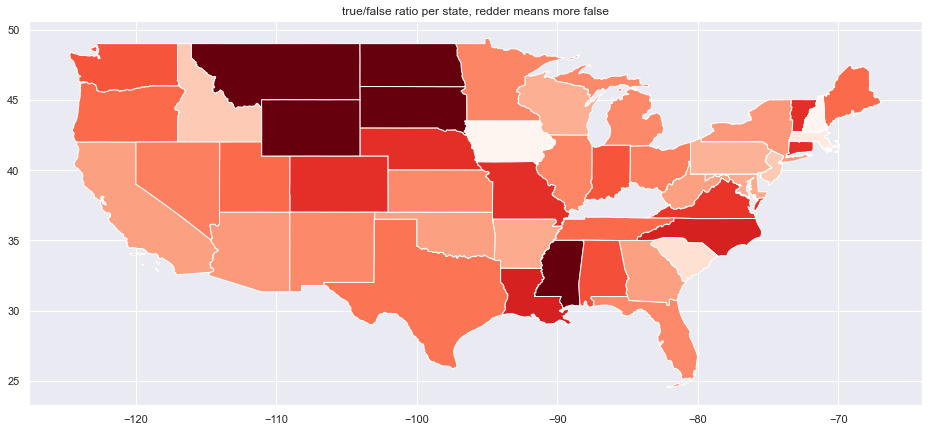

In [181]:
title = "true/false ratio per state, redder means more false"
ax = usmap.plot(column="label", cmap="Reds_r", figsize=(16, 16))
ax.set_title(title)